<a href="https://colab.research.google.com/github/GoogleCloudPlatform/training-data-analyst/blob/master/courses/fast-and-lean-data-science/01_MNIST_TPU_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MNIST on TPU (Tensor Processing Unit)<br>or GPU using tf.Keras and tf.data.Dataset
<table><tr><td><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/keras-tensorflow-tpu300px.png" width="300" alt="Keras+Tensorflow+Cloud TPU"></td></tr></table>


This sample trains an "MNIST" handwritten digit 
recognition model on a GPU or TPU backend using a Keras
model. Data are handled using the tf.data.Datset API. This is
a very simple sample provided for educational purposes. Do
not expect outstanding TPU performance on a dataset as
small as MNIST.

<h3><a href="https://cloud.google.com/gpu/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/gpu-hexagon.png" width="50"></a>  &nbsp;&nbsp;Train on GPU or TPU&nbsp;&nbsp; <a href="https://cloud.google.com/tpu/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/tpu-hexagon.png" width="50"></a></h3>

  1. Select a GPU or TPU backend (Runtime > Change runtime type) 
  1. Runtime > Run All (Watch out: the "Colab-only auth" cell requires user input)

<h3><a href="https://cloud.google.com/ml-engine/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/mlengine-hexagon.png" width="50"></a>  &nbsp;&nbsp;Deploy to ML Engine</h3>
1. At the bottom of this notebook you can deploy your trained model to ML Engine for a serverless, autoscaled, REST API experience. You will need a GCP project and a GCS bucket for this last part.

TPUs are located in Google Cloud, for optimal performance, they read data directly from Google Cloud Storage (GCS)

### Parameters

In [ ]:
BATCH_SIZE = 128 # On TPU, this will be the per-core batch size. A Cloud TPU has 8 cores so tha global TPU batch size is 1024

training_images_file   = 'gs://mnist-public/train-images-idx3-ubyte'
training_labels_file   = 'gs://mnist-public/train-labels-idx1-ubyte'
validation_images_file = 'gs://mnist-public/t10k-images-idx3-ubyte'
validation_labels_file = 'gs://mnist-public/t10k-labels-idx1-ubyte'

### Imports

In [ ]:
import os, re, math, json, shutil, pprint
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.python.platform import tf_logging
print("Tensorflow version " + tf.__version__)
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Tensorflow version 2.8.4
Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
#@title visualization utilities [RUN ME]
"""
This cell contains helper functions used for visualization
and downloads only. You can skip reading it. There is very
little useful Keras/Tensorflow code here.
"""

# Matplotlib config
plt.rc('image', cmap='gray_r')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# pull a batch from the datasets. This code is not very nice, it gets much better in eager mode (TODO)
def dataset_to_numpy_util(training_dataset, validation_dataset, N):
  
  # get one batch from each: 10000 validation digits, N training digits
  unbatched_train_ds = training_dataset.apply(tf.data.experimental.unbatch())
  v_images, v_labels = validation_dataset.make_one_shot_iterator().get_next()
  t_images, t_labels = unbatched_train_ds.batch(N).make_one_shot_iterator().get_next()
  
  # Run once, get one batch. Session.run returns numpy results
  with tf.Session() as ses:
    (validation_digits, validation_labels,
     training_digits, training_labels) = ses.run([v_images, v_labels, t_images, t_labels])
  
  # these were one-hot encoded in the dataset
  validation_labels = np.argmax(validation_labels, axis=1)
  training_labels = np.argmax(training_labels, axis=1)
  
  return (training_digits, training_labels,
          validation_digits, validation_labels)

# create digits from local fonts for testing
def create_digits_from_local_fonts(n):
  font_labels = []
  img = PIL.Image.new('LA', (28*n, 28), color = (0,255)) # format 'LA': black in channel 0, alpha in channel 1
  font1 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'DejaVuSansMono-Oblique.ttf'), 25)
  font2 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'STIXGeneral.ttf'), 25)
  d = PIL.ImageDraw.Draw(img)
  for i in range(n):
    font_labels.append(i%10)
    d.text((7+i*28,0 if i<10 else -4), str(i%10), fill=(255,255), font=font1 if i<10 else font2)
  font_digits = np.array(img.getdata(), np.float32)[:,0] / 255.0 # black in channel 0, alpha in channel 1 (discarded)
  font_digits = np.reshape(np.stack(np.split(np.reshape(font_digits, [28, 28*n]), n, axis=1), axis=0), [n, 28*28])
  return font_digits, font_labels

# utility to display a row of digits with their predictions
def display_digits(digits, predictions, labels, title, n):
  plt.figure(figsize=(13,3))
  digits = np.reshape(digits, [n, 28, 28])
  digits = np.swapaxes(digits, 0, 1)
  digits = np.reshape(digits, [28, 28*n])
  plt.yticks([])
  plt.xticks([28*x+14 for x in range(n)], predictions)
  for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
    if predictions[i] != labels[i]: t.set_color('red') # bad predictions in red
  plt.imshow(digits)
  plt.grid(None)
  plt.title(title)
  
# utility to display multiple rows of digits, sorted by unrecognized/recognized status
def display_top_unrecognized(digits, predictions, labels, n, lines):
  idx = np.argsort(predictions==labels) # sort order: unrecognized first
  for i in range(lines):
    display_digits(digits[idx][i*n:(i+1)*n], predictions[idx][i*n:(i+1)*n], labels[idx][i*n:(i+1)*n],
                   "{} sample validation digits out of {} with bad predictions in red and sorted first".format(n*lines, len(digits)) if i==0 else "", n)
    
# utility to display training and validation curves
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.grid(linewidth=1, color='white')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

### Colab-only auth for this notebook and the TPU

In [ ]:
IS_COLAB_BACKEND = 'COLAB_GPU' in os.environ  # this is always set on Colab, the value is 0 or 1 depending on GPU presence
if IS_COLAB_BACKEND:
  from google.colab import auth
  auth.authenticate_user() # Authenticates the backend and also the TPU using your credentials so that they can access your private GCS buckets

### tf.data.Dataset: parse files and prepare training and validation datasets
Please read the [best practices for building](https://www.tensorflow.org/guide/performance/datasets) input pipelines with tf.data.Dataset

In [ ]:
def read_label(tf_bytestring):
    label = tf.io.decode_raw(tf_bytestring, tf.uint8)
    label = tf.reshape(label, [])
    label = tf.one_hot(label, 10)
    return label
  
def read_image(tf_bytestring):
    image = tf.io.decode_raw(tf_bytestring, tf.uint8)
    image = tf.cast(image, tf.float32)/256.0
    image = tf.reshape(image, [28*28])
    return image
  
def load_dataset(image_file, label_file):
    imagedataset = tf.data.FixedLengthRecordDataset(image_file, 28*28, header_bytes=16)
    imagedataset = imagedataset.map(read_image, num_parallel_calls=16)
    labelsdataset = tf.data.FixedLengthRecordDataset(label_file, 1, header_bytes=8)
    labelsdataset = labelsdataset.map(read_label, num_parallel_calls=16)
    dataset = tf.data.Dataset.zip((imagedataset, labelsdataset))
    return dataset 
  
def get_training_dataset(image_file, label_file, batch_size):
    dataset = load_dataset(image_file, label_file)
    dataset = dataset.cache()  # this small dataset can be entirely cached in RAM, for TPU this is important to get good performance from such a small dataset
    dataset = dataset.shuffle(5000, reshuffle_each_iteration=True)
    dataset = dataset.repeat() # Mandatory for Keras for now
    dataset = dataset.batch(batch_size, drop_remainder=True) # drop_remainder is important on TPU, batch size must be fixed
    dataset = dataset.prefetch(-1)  # fetch next batches while training on the current one (-1: autotune prefetch buffer size)
    return dataset
  
def get_validation_dataset(image_file, label_file):
    dataset = load_dataset(image_file, label_file)
    dataset = dataset.cache() # this small dataset can be entirely cached in RAM, for TPU this is important to get good performance from such a small dataset
    dataset = dataset.batch(10000, drop_remainder=True) # 10000 items in eval dataset, all in one batch
    dataset = dataset.repeat() # Mandatory for Keras for now
    return dataset

# instantiate the datasets
training_dataset = get_training_dataset(training_images_file, training_labels_file, BATCH_SIZE)
validation_dataset = get_validation_dataset(validation_images_file, validation_labels_file)

# For TPU, we will need a function that returns the dataset
training_input_fn = lambda: get_training_dataset(training_images_file, training_labels_file, BATCH_SIZE)
validation_input_fn = lambda: get_validation_dataset(validation_images_file, validation_labels_file)

### Let's have a look at the data

Instructions for updating:
Use `tf.data.Dataset.unbatch()`.
Instructions for updating:
This is a deprecated API that should only be used in TF 1 graph mode and legacy TF 2 graph mode available through `tf.compat.v1`. In all other situations -- namely, eager mode and inside `tf.function` -- you can consume dataset elements using `for elem in dataset: ...` or by explicitly creating iterator via `iterator = iter(dataset)` and fetching its elements via `values = next(iterator)`. Furthermore, this API is not available in TF 2. During the transition from TF 1 to TF 2 you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)` to create a TF 1 graph mode style iterator for a dataset created through TF 2 APIs. Note that this should be a transient state of your code base as there are in general no guarantees about the interoperability of TF 1 and TF 2 code.


2023-03-01 03:23:57.049729: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-03-01 03:23:57.049774: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-01 03:23:57.049800: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mymnist): /proc/driver/nvidia/version does not exist
2023-03-01 03:23:57.050075: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-01 03:23:58

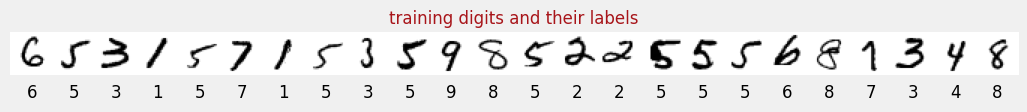

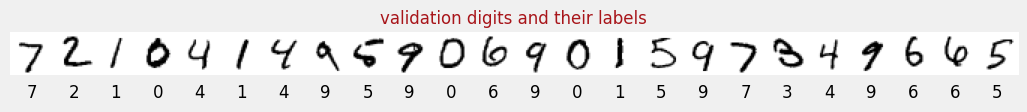

In [ ]:
N = 24
(training_digits, training_labels,
 validation_digits, validation_labels) = dataset_to_numpy_util(training_dataset, validation_dataset, N)
display_digits(training_digits, training_labels, training_labels, "training digits and their labels", N)
display_digits(validation_digits[:N], validation_labels[:N], validation_labels[:N], "validation digits and their labels", N)
font_digits, font_labels = create_digits_from_local_fonts(N)

### Keras model: 3 convolutional layers, 2 dense layers
If you are not sure what cross-entropy, dropout, softmax or batch-normalization mean, head here for a crash-course: [Tensorflow and deep learning without a PhD](https://github.com/GoogleCloudPlatform/tensorflow-without-a-phd/#featured-code-sample)

In [ ]:
# This model trains to 99.4% sometimes 99.5% accuracy in 10 epochs (with a batch size of 32)

l = tf.keras.layers
model = tf.keras.Sequential(
  [
    l.Reshape(input_shape=(28*28,), target_shape=(28, 28, 1)),

    l.Conv2D(filters=6, kernel_size=3, padding='same', use_bias=False), # no bias necessary before batch norm
    l.BatchNormalization(scale=False, center=True), # no batch norm scaling necessary before "relu"
    l.Activation('relu'), # activation after batch norm

    l.Conv2D(filters=12, kernel_size=6, padding='same', use_bias=False, strides=2),
    l.BatchNormalization(scale=False, center=True),
    l.Activation('relu'),

    l.Conv2D(filters=24, kernel_size=6, padding='same', use_bias=False, strides=2),
    l.BatchNormalization(scale=False, center=True),
    l.Activation('relu'),

    l.Flatten(),
    l.Dense(200, use_bias=False),
    l.BatchNormalization(scale=False, center=True),
    l.Activation('relu'),
    l.Dropout(0.5), # Dropout on dense layer only

    l.Dense(10, activation='softmax')
  ])

model.compile(optimizer='adam', # learning rate will be set by LearningRateScheduler
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# print model layers
model.summary()

# set up learning rate decay
lr_decay = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.0001 + 0.02 * math.pow(0.5, 1+epoch), verbose=True)

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 6)         54        
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 6)        18        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 28, 28, 6)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 12)        2592      
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 12)  

### Train and validate the model

In [11]:
EPOCHS = 10
steps_per_epoch = 60000//BATCH_SIZE  # 60,000 items in this dataset
tpu = None
trained_model = model

# Counting steps and batches on TPU: the tpu.keras_to_tpu_model API regards the batch size of the input dataset
# as the per-core batch size. The effective batch size is 8x more because Cloud TPUs have 8 cores. It increments
# the step by +8 everytime a global batch (8 per-core batches) is processed. Therefore batch size and steps_per_epoch
# settings can stay as they are for TPU training. The training will just go faster.
# Warning: this might change in the final version of the Keras/TPU API.

if tpu: # TPU detection
  tpu = tf.contrib.cluster_resolver.TPUClusterResolver() # Picks up a connected TPU on Google's Colab, ML Engine, Kubernetes and Deep Learning VMs accessed through the 'ctpu up' utility
  #tpu = tf.contrib.cluster_resolver.TPUClusterResolver('MY_TPU_NAME') # If auto-detection does not work, you can pass the name of the TPU explicitly (tip: on a VM created with "ctpu up" the TPU has the same name as the VM)
else:
  print('Training on GPU/CPU')
  
if tpu: # TPU training
  strategy = tf.contrib.tpu.TPUDistributionStrategy(tpu)
  trained_model = tf.contrib.tpu.keras_to_tpu_model(model, strategy=strategy)
  # Work in progress: reading directly from dataset object not yet implemented
  # for Keras/TPU. Keras/TPU needs a function that returns a dataset.
  history = trained_model.fit(training_input_fn, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                            validation_data=validation_input_fn, validation_steps=1, callbacks=[lr_decay])
else: # GPU/CPU training
  history = trained_model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                              validation_data=validation_dataset, validation_steps=1, callbacks=[lr_decay])  

Training on GPU/CPU
Train on 468 steps, validate on 1 steps

Epoch 1: LearningRateScheduler setting learning rate to 0.0101.
Epoch 1/10
468/468 [==============================] - ETA: 0s - batch: 233.5000 - size: 1.0000 - loss: 0.0887 - acc: 0.9730

/opt/conda/lib/python3.7/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


468/468 [==============================] - 34s 69ms/step - batch: 233.5000 - size: 1.0000 - loss: 0.0887 - acc: 0.9730 - val_loss: 0.0613 - val_acc: 0.9796 - lr: 0.0101

Epoch 2: LearningRateScheduler setting learning rate to 0.0051.
Epoch 2/10
  2/468 [..............................] - ETA: 28s - batch: 0.5000 - size: 1.0000 - loss: 0.0354 - acc: 0.9844    

2023-03-01 03:29:39.672718: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


468/468 [==============================] - 32s 68ms/step - batch: 233.5000 - size: 1.0000 - loss: 0.0445 - acc: 0.9868 - val_loss: 0.0331 - val_acc: 0.9889 - lr: 0.0051

Epoch 3: LearningRateScheduler setting learning rate to 0.0026.
Epoch 3/10
  2/468 [..............................] - ETA: 29s - batch: 0.5000 - size: 1.0000 - loss: 0.0187 - acc: 0.9961    

2023-03-01 03:30:11.399474: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


468/468 [==============================] - ETA: 0s - batch: 233.5000 - size: 1.0000 - loss: 0.0281 - acc: 0.9914

2023-03-01 03:30:42.066057: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


468/468 [==============================] - 32s 67ms/step - batch: 233.5000 - size: 1.0000 - loss: 0.0281 - acc: 0.9914 - val_loss: 0.0223 - val_acc: 0.9924 - lr: 0.0026

Epoch 4: LearningRateScheduler setting learning rate to 0.00135.
Epoch 4/10
468/468 [==============================] - 32s 67ms/step - batch: 233.5000 - size: 1.0000 - loss: 0.0196 - acc: 0.9939 - val_loss: 0.0233 - val_acc: 0.9920 - lr: 0.0014

Epoch 5: LearningRateScheduler setting learning rate to 0.0007250000000000001.
Epoch 5/10
  2/468 [..............................] - ETA: 29s - batch: 0.5000 - size: 1.0000 - loss: 0.0068 - acc: 1.0000    

2023-03-01 03:31:14.519281: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


468/468 [==============================] - 31s 66ms/step - batch: 233.5000 - size: 1.0000 - loss: 0.0153 - acc: 0.9953 - val_loss: 0.0196 - val_acc: 0.9937 - lr: 7.2500e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.0004125.
Epoch 6/10
  3/468 [..............................] - ETA: 28s - batch: 1.0000 - size: 1.0000 - loss: 0.0060 - acc: 0.9974   

2023-03-01 03:31:45.329708: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


468/468 [==============================] - 31s 67ms/step - batch: 233.5000 - size: 1.0000 - loss: 0.0132 - acc: 0.9961 - val_loss: 0.0190 - val_acc: 0.9941 - lr: 4.1250e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.00025625.
Epoch 7/10
  3/468 [..............................] - ETA: 28s - batch: 1.0000 - size: 1.0000 - loss: 0.0223 - acc: 0.9896       

2023-03-01 03:32:16.696727: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


468/468 [==============================] - 31s 65ms/step - batch: 233.5000 - size: 1.0000 - loss: 0.0117 - acc: 0.9966 - val_loss: 0.0191 - val_acc: 0.9936 - lr: 2.5625e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.000178125.
Epoch 8/10
  3/468 [..............................] - ETA: 28s - batch: 1.0000 - size: 1.0000 - loss: 0.0104 - acc: 0.9974   

2023-03-01 03:32:47.206093: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


468/468 [==============================] - 31s 67ms/step - batch: 233.5000 - size: 1.0000 - loss: 0.0100 - acc: 0.9972 - val_loss: 0.0182 - val_acc: 0.9938 - lr: 1.7813e-04

Epoch 9: LearningRateScheduler setting learning rate to 0.0001390625.
Epoch 9/10
  3/468 [..............................] - ETA: 28s - batch: 1.0000 - size: 1.0000 - loss: 0.0087 - acc: 0.9974   

2023-03-01 03:33:18.401199: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


468/468 [==============================] - 31s 65ms/step - batch: 233.5000 - size: 1.0000 - loss: 0.0092 - acc: 0.9972 - val_loss: 0.0179 - val_acc: 0.9939 - lr: 1.3906e-04

Epoch 10: LearningRateScheduler setting learning rate to 0.00011953125000000001.
Epoch 10/10
  2/468 [..............................] - ETA: 29s - batch: 0.5000 - size: 1.0000 - loss: 0.0048 - acc: 1.0000    

2023-03-01 03:33:48.926989: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


468/468 [==============================] - 31s 67ms/step - batch: 233.5000 - size: 1.0000 - loss: 0.0093 - acc: 0.9975 - val_loss: 0.0180 - val_acc: 0.9938 - lr: 1.1953e-04


### Visualize training and validation curves

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])


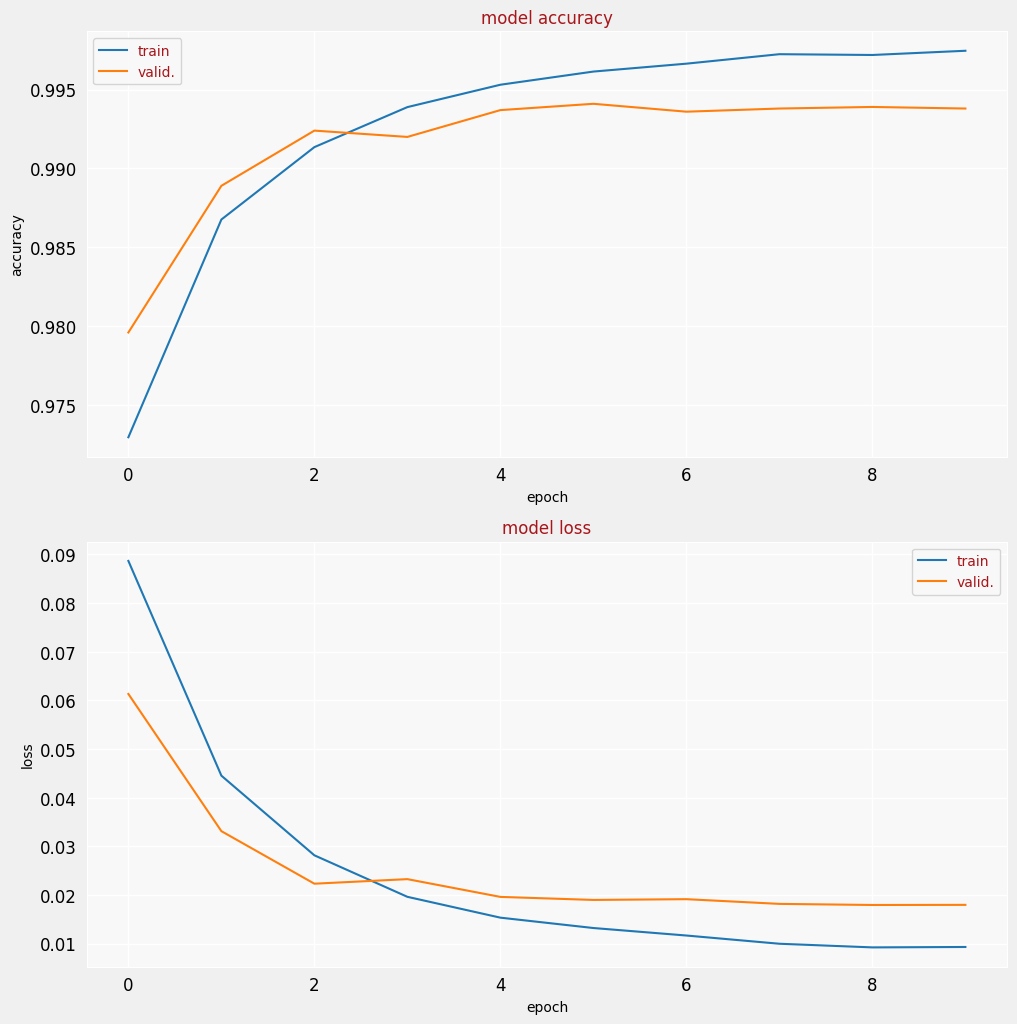

In [12]:
print(history.history.keys())
display_training_curves(history.history['acc'], history.history['val_acc'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

### Visualize predictions

/opt/conda/lib/python3.7/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


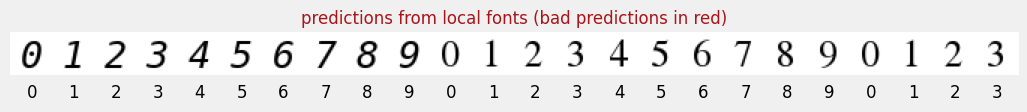

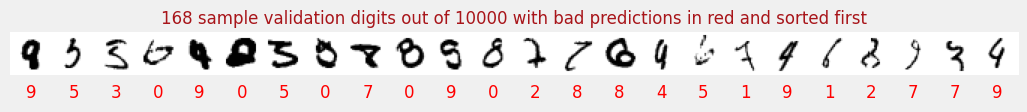

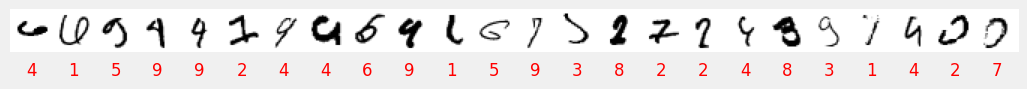

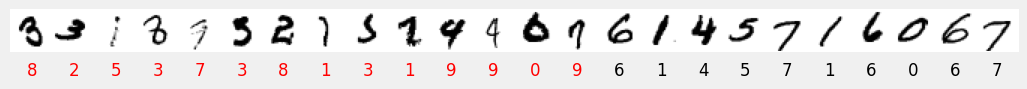

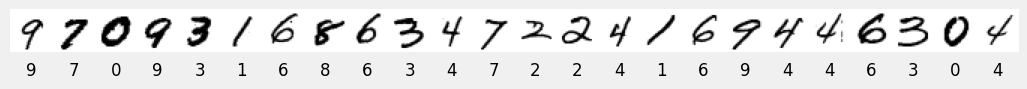

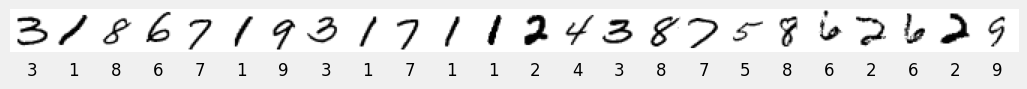

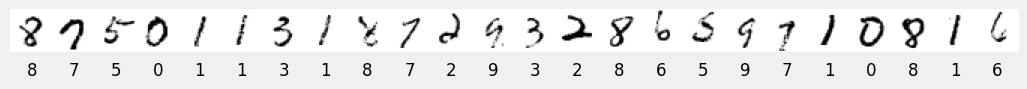

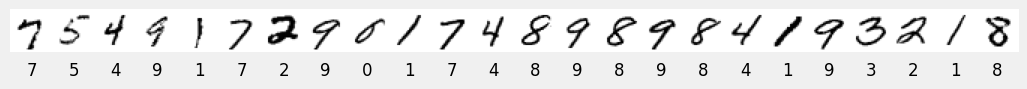

In [13]:
# recognize digits from local fonts
probabilities = trained_model.predict(font_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1)
display_digits(font_digits, predicted_labels, font_labels, "predictions from local fonts (bad predictions in red)", N)

# recognize validation digits
probabilities = trained_model.predict(validation_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1)
display_top_unrecognized(validation_digits, predicted_labels, validation_labels, N, 7)

## Deploy the trained model to ML Engine

Push your trained model to production on ML Engine for a serverless, autoscaled, REST API experience.

You will need a GCS bucket and a GCP project for this.
Models deployed on ML Engine autoscale to zero if not used. There will be no ML Engine charges after you are done testing.
Google Cloud Storage incurs charges. Empty the bucket after deployment if you want to avoid these. Once the model is deployed, the bucket is not useful anymore.

### Configuration

In [15]:
PROJECT = "mymnist-379300" #@param {type:"string"}
BUCKET = "gs://mymnist-bucket"  #@param {type:"string", default:"jddj"}
NEW_MODEL = True #@param {type:"boolean"}
MODEL_NAME = "colabmnist" #@param {type:"string"}
MODEL_VERSION = "v0" #@param {type:"string"}

assert PROJECT, 'For this part, you need a GCP project. Head to http://console.cloud.google.com/ and create one.'
assert re.search(r'gs://.+', BUCKET), 'For this part, you need a GCS bucket. Head to http://console.cloud.google.com/storage and create one.'

### Export the model for serving from ML Engine

In [55]:
class ServingInput(tf.keras.layers.Layer):
  # the important detail in this boilerplate code is "trainable=False"
  def __init__(self, name, dtype, batch_input_shape=None):
    super(ServingInput, self).__init__(trainable=False, name=name, dtype=dtype, batch_input_shape=batch_input_shape)
  def get_config(self):
    return {'batch_input_shape': self._batch_input_shape, 'dtype': self.dtype, 'name': self.name }

  def call(self, inputs):
    # When the deployed model is called through its REST API,
    # the JSON payload is parsed automatically, transformed into
    # a tensor and passed to this input layer. You can perform
    # additional transformations, such as decoding JPEGs for example,
    # before sending the data to your model. However, you can only
    # use tf.xxxx operations.
    return inputs

# little wrinkle: must copy the model from TPU to CPU manually. This is a temporary workaround.
tf_logging.set_verbosity(tf_logging.INFO)
restored_model = model
restored_model.set_weights(trained_model.get_weights()) # this copied the weights from TPU, does nothing on GPU
tf_logging.set_verbosity(tf_logging.WARN)

# add the serving input layer
serving_model = tf.keras.Sequential()
serving_model.add(ServingInput('serving', tf.float32, (None, 28*28)))
serving_model.add(restored_model)
export_path = os.path.join("saved_model", 'keras_export')
tf.keras.models.save_model(serving_model, export_path, save_format='tf')  # export he model to your bucket
print("Model exported to: ", export_path)

Model exported to:  saved_model/keras_export


In [56]:
# Move to bucket
!gsutil cp -r {export_path} {BUCKET} 

Copying file://saved_model/keras_export/saved_model.pb [Content-Type=application/octet-stream]...
Copying file://saved_model/keras_export/keras_metadata.pb [Content-Type=application/octet-stream]...
Copying file://saved_model/keras_export/variables/variables.index [Content-Type=application/octet-stream]...
Copying file://saved_model/keras_export/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
- [4 files][  3.3 MiB/  3.3 MiB]                                                
Operation completed over 4 objects/3.3 MiB.                                      


### Deploy the model
This uses the command-line interface. You can do the same thing through the ML Engine UI at https://console.cloud.google.com/mlengine/models


In [42]:
# Create the model
if NEW_MODEL:
  !gcloud ai-platform models create {MODEL_NAME} --project={PROJECT} --regions=us-central1

Using endpoint [https://ml.googleapis.com/]
API [ml.googleapis.com] not enabled on project [922883319102]. Would you like to
 enable and retry (this will take a few minutes)? (y/N)?  ^C


Command killed by keyboard interrupt



In [46]:
# Create a version of this model (you can add --async at the end of the line to make this call non blocking)
# Additional config flags are available: https://cloud.google.com/ml-engine/reference/rest/v1/projects.models.versions
# You can also deploy a model that is stored locally by providing a --staging-bucket=... parameter
!echo "Deployment takes a couple of minutes. You can watch your deployment here: https://console.cloud.google.com/mlengine/models/{MODEL_NAME}"
#"gcloud ml-engine versions create {MODEL_VERSION} --model={MODEL_NAME} --origin={export_path} --project={PROJECT} --runtime-version=1.10"
gcloud ai-platform versions create v0 --model=colabmnist --origin=gs://mymnist-bucket/keras_export --project=mymnist-379300 --runtime-version=2.8 --machine-type=n1-standard-4 --framework tensorflow

Deployment takes a couple of minutes. You can watch your deployment here: https://console.cloud.google.com/mlengine/models/colabmnist
gcloud ml-engine versions create v0 --model=colabmnist --origin=saved_model/keras_export --project=mymnist-379300 --runtime-version=1.10


### Test the deployed model
Your model is now available as a REST API. Let us try to call it. The cells below use the "gcloud ml-engine"
command line tool but any tool that can send a JSON payload to a REST endpoint will work.

In [57]:
# prepare digits to send to online prediction endpoint
digits = np.concatenate((font_digits, validation_digits[:100-N]))
labels = np.concatenate((font_labels, validation_labels[:100-N]))
with open("digits.json", "w") as f:
  for digit in digits:
    # the format for ML Engine online predictions is: one JSON object per line
    data = json.dumps({"serving_input": digit.tolist()})  # "serving_input" because the ServingInput layer was named "serving". Keras appends "_input"
    f.write(data+'\n')

In [61]:
# Request online predictions from deployed model (REST API) using the "gcloud ml-engine" command line.
predictions = !gcloud ml-engine predict --model={MODEL_NAME} --json-instances digits.json --project={PROJECT} --version {MODEL_VERSION}
print(predictions)

# probabilities = np.stack([json.loads(p) for p in predictions[1:]]) # first line is the name of the input layer: drop it, parse the rest
# predictions = np.argmax(probabilities, axis=1)
# display_top_unrecognized(digits, predictions, labels, N, 100//N)

['WARNING: The `gcloud ml-engine` commands have been renamed and will soon be removed. Please use `gcloud ai-platform` instead.', 'Using endpoint [https://us-central1-ml.googleapis.com/]', '[[0.999979496, 3.3671772e-09, 4.19189917e-07, 7.89339616e-09, 2.57995203e-09, 6.72405491e-08, 5.09216e-06, 9.65639373e-08, 8.8968718e-06, 6.05617333e-06], [2.25864387e-05, 0.953054547, 0.0339431688, 0.000521750655, 1.2488764e-06, 6.45801583e-06, 1.35618492e-07, 0.0124179116, 1.22036852e-06, 3.1022133e-05], [2.28089746e-07, 2.89350851e-07, 0.999937057, 1.6879834e-06, 1.79695581e-11, 7.20872667e-11, 8.09516412e-11, 6.04466222e-05, 2.26428071e-07, 1.575018e-09], [8.56625765e-15, 6.7727865e-11, 6.05945127e-10, 1.0, 1.74111685e-16, 2.49666261e-08, 3.36570786e-15, 1.03406539e-09, 3.2539631e-09, 4.07024192e-10], [1.68335337e-05, 2.33431601e-05, 4.7196907e-05, 1.39417736e-07, 0.998942316, 5.37641e-07, 8.3193554e-06, 2.82234555e-06, 8.95310961e-07, 0.00095774472], [2.33435775e-14, 4.84598e-12, 2.54124681e-16

In [62]:
!pwd

/home/jupyter/tutorials/fast-and-lean-data-science


## License



---


author: Martin Gorner<br>
twitter: @martin_gorner


---


Copyright 2018 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


---


This is not an official Google product but sample code provided for an educational purpose
